In [1]:
from langchain.chat_models import init_chat_model

In [2]:
import os
from dotenv import load_dotenv
load_dotenv()

os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")

In [3]:
from langchain.chat_models import init_chat_model

# Replace 'llama3-8b-8192' with the specific Groq model you want to use
llm = init_chat_model("groq:qwen/qwen3-32b")

llm.invoke("test line")

AIMessage(content='<think>\nOkay, the user wrote "test line". Let me see what they need. It\'s pretty brief. Maybe they just want a simple response to confirm it\'s working? Or perhaps they\'re testing if the system is responsive. I should acknowledge their message and offer further assistance. Let me check if there\'s any hidden context, but since there\'s none, a straightforward reply should be best. Let me make sure to keep it friendly and open-ended.\n</think>\n\nHello! It seems like you might be testing a message. If you have any questions or need assistance, feel free to let me know. How can I help you today?', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 130, 'prompt_tokens': 10, 'total_tokens': 140, 'completion_time': 0.304144218, 'prompt_time': 0.03445463, 'queue_time': 0.04515356, 'total_time': 0.338598848}, 'model_name': 'qwen/qwen3-32b', 'system_fingerprint': 'fp_5cf921caa2', 'finish_reason': 'stop', 'logprobs': None}, id='run--85d9d60a-3941

## **Building Agent without MCP**

In [4]:
## Search tools
import getpass

if not os.environ.get("TAVILY_API_KEY"):
    os.environ["TAVILY_API_KEY"] = getpass.getpass("Tavily API key:\n")

In [5]:
from langchain_tavily import TavilySearch

search_tool = TavilySearch(
    max_results=5,
    topic="general",
    # include_answer=False,
    # include_raw_content=False,
    # include_images=False,
    # include_image_descriptions=False,
    # search_depth="basic",
    # time_range="day",
    # include_domains=None,
    # exclude_domains=None
)

In [6]:
llm_with_tools =llm.bind_tools([search_tool], tool_choice="any") 

In [7]:
response =llm_with_tools.invoke("can you tell me the current weather of khulna.") 

In [8]:
response

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'gw8btp5ey', 'function': {'arguments': '{"query":"current weather Khulna"}', 'name': 'tavily_search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 391, 'prompt_tokens': 1140, 'total_tokens': 1531, 'completion_time': 0.940214026, 'prompt_time': 0.061253799, 'queue_time': 0.055023481, 'total_time': 1.001467825}, 'model_name': 'qwen/qwen3-32b', 'system_fingerprint': 'fp_5cf921caa2', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--f5f47d96-9f42-454e-925a-6d23d12637c5-0', tool_calls=[{'name': 'tavily_search', 'args': {'query': 'current weather Khulna'}, 'id': 'gw8btp5ey', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1140, 'output_tokens': 391, 'total_tokens': 1531})

In [9]:
response.tool_calls

[{'name': 'tavily_search',
  'args': {'query': 'current weather Khulna'},
  'id': 'gw8btp5ey',
  'type': 'tool_call'}]

In [10]:
tools_msg = search_tool.invoke(response.tool_calls[0]["args"])

In [11]:
tools_msg

{'query': 'current weather Khulna',
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'title': 'Weather in Khulna',
   'url': 'https://www.weatherapi.com/',
   'content': "{'location': {'name': 'Khulna', 'region': '', 'country': 'Bangladesh', 'lat': 22.8, 'lon': 89.55, 'tz_id': 'Asia/Dhaka', 'localtime_epoch': 1755882352, 'localtime': '2025-08-22 23:05'}, 'current': {'last_updated_epoch': 1755882000, 'last_updated': '2025-08-22 23:00', 'temp_c': 25.7, 'temp_f': 78.3, 'is_day': 0, 'condition': {'text': 'Light rain shower', 'icon': '//cdn.weatherapi.com/weather/64x64/night/353.png', 'code': 1240}, 'wind_mph': 4.5, 'wind_kph': 7.2, 'wind_degree': 207, 'wind_dir': 'SSW', 'pressure_mb': 1002.0, 'pressure_in': 29.6, 'precip_mm': 0.35, 'precip_in': 0.01, 'humidity': 92, 'cloud': 88, 'feelslike_c': 29.3, 'feelslike_f': 84.7, 'windchill_c': 25.7, 'windchill_f': 78.3, 'heatindex_c': 29.3, 'heatindex_f': 84.7, 'dewpoint_c': 24.4, 'dewpoint_f': 75.9, 'vis_km': 10.0, 'vis_

## **Build the simple agent with Tools**

In [12]:
from langgraph.graph import StateGraph, MessagesState, START, END

class AgentState(MessagesState):
    pass

In [14]:
def assistant(state: AgentState):
    print("---Assistant---")
    question = state['messages'][-1]
    
    response = llm_with_tools.invoke(question)
    
    return {
        "messages": response
    }

In [15]:
tools = [search_tool]

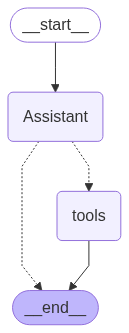

In [18]:
from langgraph.prebuilt import ToolNode, tools_condition

builder = StateGraph(AgentState)

builder.add_node("Assistant", assistant)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START, "Assistant")
builder.add_conditional_edges(
    "Assistant",
    tools_condition
)

app = builder.compile()

app